In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import os
import cv2

import matplotlib.pyplot as plt


# **Prepare Dataset**

In [14]:
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))  # Extract filename without extension
    subject_id, etc = filename.split('__')  # Split into ID and the rest of the string

    details = etc.split('_')  # Split the remaining string by underscores

    if len(details) == 4:  # Real image format
        gender, lr, finger, _ = details
    elif len(details) == 5:  # Altered image format
        gender, lr, finger, _, _ = details
    else:
        raise ValueError(f"Unexpected filename format: {filename}")

    # Encode gender
    gender = 0 if gender == 'M' else 1
    # Encode left/right hand
    lr = 0 if lr == 'Left' else 1
    # Encode finger type
    finger_map = {'thumb': 0, 'index': 1, 'middle': 2, 'ring': 3, 'little': 4}
    finger = finger_map.get(finger, -1)  # Default to -1 if finger is unrecognized

    if finger == -1:
        raise ValueError(f"Unexpected finger type in filename: {filename}")

    # Return as a NumPy array
    return np.array([gender, lr, finger], dtype=np.uint16)


In [15]:
img_size = 96


def loading_data(path,boolean):
    data = []
    for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),boolean)
            
            data.append([label[0], img_resize ])
            if len(data) % 1000 == 0:
                print(len(data))
    return data

In [16]:
Real_path = "../input/socofing/SOCOFing/Real"
Easy_path = "../input/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "../input/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "../input/socofing/SOCOFing/Altered/Altered-Hard"



# **Split Dataset**

In [30]:
from sklearn.model_selection import train_test_split

# Combine all data
all_data = Real_data + Easy_data + Medium_data + Hard_data

# Separate features (images) and labels
img, labels = [], []
for label, feature in all_data:
    labels.append(label)
    img.append(feature)

# Normalize images and reshape
img = np.array(img).reshape(-1, img_size, img_size, 1) / 255.0
labels = np.array(labels)

# Split data into train (70%), test (20%), and validation (10%)
X_train, X_temp, y_train, y_temp = train_test_split(img, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42)

# Output shapes to verify
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


Training data shape: (38689, 96, 96, 1) (38689,)
Testing data shape: (11059, 96, 96, 1) (11059,)
Validation data shape: (5522, 96, 96, 1) (5522,)


In [31]:
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)

In [32]:
labels = np.array(labels)

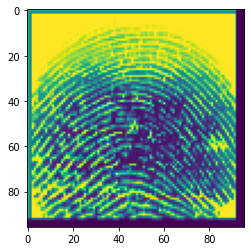

In [33]:
plt.imshow(train_data[5000])

# **Model**

In [21]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = Sequential([
Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
MaxPooling2D(2),
Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
MaxPooling2D(2),
Flatten(),
Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
Dense(1, activation = 'sigmoid'),
])
model.summary()


model.compile(optimizer = optimizers.Adam(1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [34]:
type(labels)

numpy.ndarray

In [35]:
# Import necessary libraries
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=24,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/24
303/303 [==============================] - 5s 17ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0409 - val_accuracy: 0.9877
Epoch 2/24
303/303 [==============================] - 4s 15ms/step - loss: 0.0171 - accuracy: 0.9949 - val_loss: 0.0246 - val_accuracy: 0.9947
Epoch 3/24
303/303 [==============================] - 4s 15ms/step - loss: 0.0082 - accuracy: 0.9985 - val_loss: 0.0240 - val_accuracy: 0.9957
Epoch 4/24
303/303 [==============================] - 4s 15ms/step - loss: 0.0049 - accuracy: 0.9996 - val_loss: 0.0212 - val_accuracy: 0.9955
Epoch 5/24
303/303 [==============================] - 5s 15ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0192 - val_accuracy: 0.9957
Epoch 6/24
303/303 [==============================] - 5s 15ms/step - loss: 0.0047 - accuracy: 0.9995 - val_loss: 0.0196 - val_accuracy: 0.9967
Epoch 7/24
303/303 [==============================] - 4s 15ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.0183 - val_accuracy: 0.9962

# **Model Evaluation**

In [79]:
model.evaluate(X_test,y_test)
model.evaluate(X_train,y_train)
model.evaluate(X_val,y_val)

173/173 [==============================] - 1s 3ms/step - loss: 0.0183 - accuracy: 0.9962


[0.018343599513173103, 0.9961970448493958]

# **Confusion Matrix**

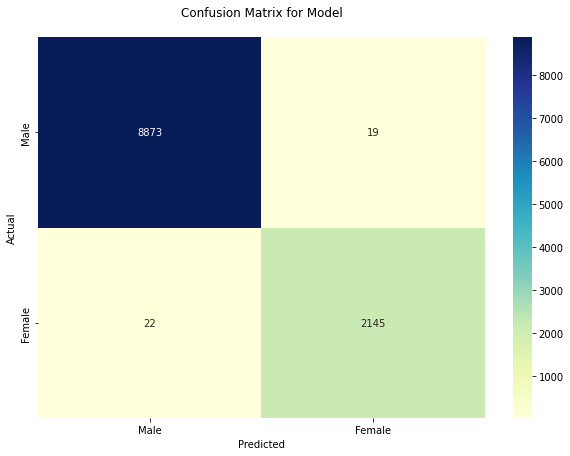

Number of Male samples in y_test: 8892
Number of Female samples in y_test: 2167


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict labels for the test set
preds = model.predict(X_test)  # Predict probabilities
preds = (preds >= 0.5).astype(np.int32)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, preds)

# Create confusion matrix DataFrame
df_cm = pd.DataFrame(cm, index=['Male', 'Female'], columns=['Male', 'Female'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.title("Confusion Matrix for Model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Additional debug output
print(f"Number of Male samples in y_test: {np.sum(y_test == 0)}")
print(f"Number of Female samples in y_test: {np.sum(y_test == 1)}")


# **Save Weights**

In [40]:
model.save('GenderFPP.h5')

# **Testing on our collected Dataest**

In [41]:
import cv2
import numpy as np

def preprocess_image(image_path, img_size):
    """
    Load and preprocess an image for model prediction.
    
    Args:
    - image_path (str): Path to the image file.
    - img_size (int): Target size for resizing (img_size x img_size).
    
    Returns:
    - np.array: Preprocessed image ready for model input.
    """
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image
    img_resized = cv2.resize(img, (img_size, img_size))
    
    # Normalize pixel values
    img_normalized = img_resized / 255.0
    
    # Reshape to add batch and channel dimensions
    img_reshaped = img_normalized.reshape(1, img_size, img_size, 1)
    
    return img_reshaped


[[0.74093014]]
Predicted Label: Female


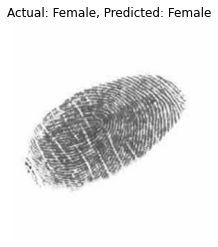

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the external image
image_path = "/kaggle/input/yarabbb/14__f_l_thumb_3_g.jpg"  

# Preprocess the image
processed_image = preprocess_image(image_path, img_size)

# Make a prediction
prediction = model.predict(processed_image)
print(prediction)

# Interpret the prediction
predicted_label = "Male" if prediction[0] < 0.6 else "Female"
print(f"Predicted Label: {predicted_label}")

# Extract the actual label from the image filename
filename = os.path.basename(image_path)
actual_label = "Female" if "f" in filename.lower() else "Male" 

# Load the image for visualization
original_img = cv2.imread(image_path)

# Convert the image from BGR (OpenCV default) to RGB (for displaying with matplotlib)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display the image with the predicted label and actual label
plt.imshow(original_img_rgb)
plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
plt.axis("off")  # Turn off axis labels
plt.show()


[[0.33241874]]
Predicted Label: Male


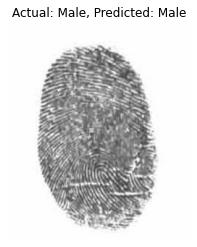

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the external image
image_path = "/kaggle/input/yarabbb/11__m_r_thumb_3_g.jpg"  

# Preprocess the image
processed_image = preprocess_image(image_path, img_size)

# Make a prediction
prediction = model.predict(processed_image)
print(prediction)

# Interpret the prediction
predicted_label = "Male" if prediction[0] < 0.6 else "Female"
print(f"Predicted Label: {predicted_label}")

# Extract the actual label from the image filename
filename = os.path.basename(image_path)
actual_label = "Female" if "f" in filename.lower() else "Male" 

# Load the image for visualization
original_img = cv2.imread(image_path)

# Convert the image from BGR (OpenCV default) to RGB (for displaying with matplotlib)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display the image with the predicted label and actual label
plt.imshow(original_img_rgb)
plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
plt.axis("off")  # Turn off axis labels
plt.show()


[[0.0447305]]
Predicted Label: Male


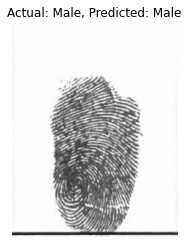

In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the external image
image_path = "/kaggle/input/yarabbb/10__m_l_thumb_3_g.jpg"  

# Preprocess the image
processed_image = preprocess_image(image_path, img_size)

# Make a prediction
prediction = model.predict(processed_image)
print(prediction)

# Interpret the prediction
predicted_label = "Male" if prediction[0] < 0.6 else "Female"
print(f"Predicted Label: {predicted_label}")

# Extract the actual label from the image filename
filename = os.path.basename(image_path)
actual_label = "Female" if "f" in filename.lower() else "Male" 

# Load the image for visualization
original_img = cv2.imread(image_path)

# Convert the image from BGR (OpenCV default) to RGB (for displaying with matplotlib)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display the image with the predicted label and actual label
plt.imshow(original_img_rgb)
plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
plt.axis("off")  # Turn off axis labels
plt.show()
